In [5]:
from matplotlib import pyplot as plt
from torch import nn
from tqdm import tqdm
from dataset.FastPatchExtractor import FastPatchDataset, FastPatchExtractor
from operators.noise_operator import NoiseOperator
import torch
from patchNR.model import create_NF

In [6]:

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cpu


In [7]:
mean=0
std = 20
operator = NoiseOperator(mean, std, device=DEVICE)

In [8]:
rec_image = FastPatchDataset('data/material_pt_nr/test.png', 9, device=DEVICE).images[0]
deg_rec_image = operator(rec_image)

In [9]:
#fig, axes = plt.subplots(1, 3, figsize=(10, 5))
#axes[0].imshow(rec_image.squeeze(), cmap='gray')
#axes[0].set_title('Clean image')
#axes[0].axis('off')
#axes[1].imshow(deg_rec_image.squeeze(), cmap='gray')
#axes[1].set_title(f'With Operator')
#axes[1].axis('off')
#axes[2].imshow((deg_rec_image-rec_image).squeeze(), cmap='gray')
#axes[2].set_title(f'Diff')
#axes[2].axis('off')
#plt.tight_layout()
#plt.show()

In [10]:
weight = 'patchNR/patchNR_weights/weights_material.pth'

In [12]:
patch_size = 6
num_layers = 5
subnet_nodes = 512
net = create_NF(num_layers, subnet_nodes, dimension=patch_size**2)
weights = torch.load(weight, map_location=DEVICE)
net.load_state_dict(weights['net_state_dict'])
net.to(DEVICE)

ReversibleGraphNet(
  (module_list): ModuleList(
    (0): GLOWCouplingBlock(
      (subnet1): Sequential(
        (0): Linear(in_features=18, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
        (3): ReLU()
        (4): Linear(in_features=512, out_features=36, bias=True)
      )
      (subnet2): Sequential(
        (0): Linear(in_features=18, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
        (3): ReLU()
        (4): Linear(in_features=512, out_features=36, bias=True)
      )
    )
    (1): PermuteRandom()
    (2): GLOWCouplingBlock(
      (subnet1): Sequential(
        (0): Linear(in_features=18, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
        (3): ReLU()
        (4): Linear(in_features=512, out_features=36, bias=True)
      )
      (subnet2): Sequential(
        (0): Lin

In [17]:
def reconstruct(img, lam, patch_size, n_patches_out, model, n_iter_max):
    """
    Defines the reconstruction using patchNR as regularizer
    """

    # fixed parameters
    obs = img.to(DEVICE)
    operator = NoiseOperator(mean=0, std=20)
    center = False
    init = obs
    pad_size = 4 #pad the image before extracting patches to avoid boundary effects
    pad = [pad_size]*4

    # create patch extractors
    patch_extractor = FastPatchExtractor(patch_size, pad=False, center=center)

    # intialize optimizer for image
    fake_img = init.clone().detach().requires_grad_(True)
    optim_img = torch.optim.Adam([fake_img], lr=0.01)

    bar = tqdm(range(n_iter_max))
    # Main loop
    for it in bar:
        optim_img.zero_grad()
        tmp = nn.functional.pad(fake_img, pad, mode='reflect')
        fake_data = patch_extractor.extract(tmp, n_patches_out)

        #patchNR
        pred_inv, log_det_inv = model(fake_data,rev=True)
        reg = torch.mean(torch.sum(pred_inv**2,dim=1)/2) - torch.mean(log_det_inv)

        #data fidelity
        data_fid = torch.sum((operator(fake_img) - obs)**2)

        #loss
        loss = data_fid + lam*reg
        bar.set_description_str('D/R: {data:.2f}  - {reg:.2f} | L: {loss:.2f} '.format(data=data_fid, reg=reg, loss=loss))
        loss.backward()
        optim_img.step()
    return fake_img

In [18]:
lam = 2.5
n_pat = 40000
iteration = 100
rec = reconstruct(deg_rec_image, lam = lam, patch_size = patch_size, n_patches_out = n_pat,
              model = net, n_iter_max = iteration)

D/R: 2277.05  - 36.43 | L: 2368.14 :   3%|▎         | 3/100 [00:13<07:14,  4.48s/it]


KeyboardInterrupt: 

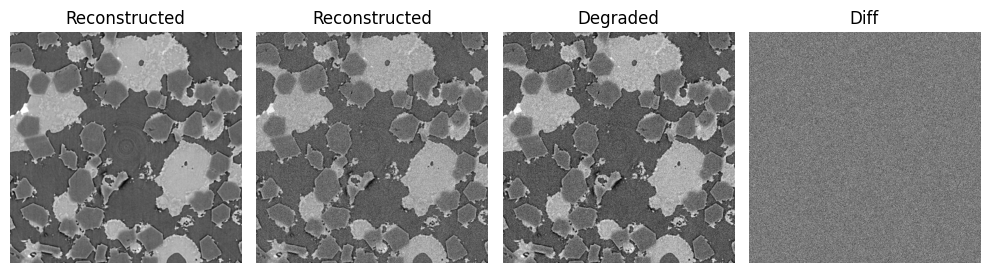

In [80]:
reconstructed = rec.detach()
# Create a figure with two subplots arranged horizontally
fig, axes = plt.subplots(1, 4, figsize=(10, 5))
axes[0].imshow(rec_image.squeeze(), cmap='gray')
axes[0].set_title('Reconstructed')
axes[0].axis('off')
axes[1].imshow(reconstructed.squeeze(), cmap='gray')
axes[1].set_title('Reconstructed')
axes[1].axis('off')
axes[2].imshow(deg_rec_image.squeeze(), cmap='gray')
axes[2].set_title(f'Degraded')
axes[2].axis('off')
axes[3].imshow((rec_image-reconstructed).squeeze(), cmap='gray')
axes[3].set_title(f'Diff')
axes[3].axis('off')
plt.tight_layout()
plt.show()

In [81]:
patch_extractor = FastPatchExtractor(50)

In [89]:
ground_truth = torch.reshape(patch_extractor.extract(rec_image)[3], (50,50))
reconstructed = torch.reshape(patch_extractor.extract(reconstructed)[3], (50,50))
deg_rec_image = torch.reshape(patch_extractor.extract(deg_rec_image)[3], (50,50))

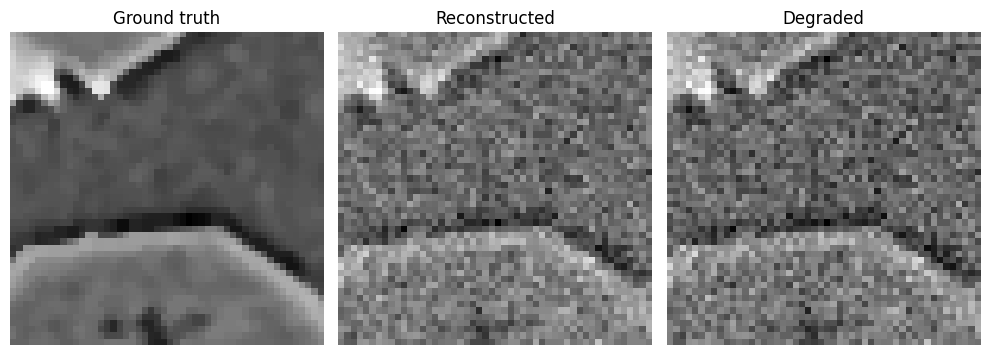

In [92]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(ground_truth, cmap='gray')
axes[0].set_title('Ground truth')
axes[0].axis('off')
axes[1].imshow(reconstructed, cmap='gray')
axes[1].set_title('Reconstructed')
axes[1].axis('off')
axes[2].imshow(deg_rec_image, cmap='gray')
axes[2].set_title(f'Degraded')
axes[2].axis('off')
plt.tight_layout()
plt.show()